In [ ]:
#connect to Google Drive
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd drive/MyDrive/EarlyStopping_for_DIP/

In [2]:
import numpy as np
import skimage.metrics
import torch
import torch.optim 
import os
from third_party.models import *
from third_party.utils.denoising_utils import *
import matplotlib.pyplot as plt
# import pandas as pd
import seaborn as sns
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
os.environ['CUDA_VISIBLE_DEVICES'] ='0'

c:\Users\fubon\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] The specified procedure could not be found'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
c:\Users\fubon\anaconda3\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor
patience = 1000
width = 128
alpha = 0.1
lr = 0.01
alg = 'adam'
num_iter = 1000
l1 = False

In [4]:
class EWMVar():
    def __init__(self, alpha, p):
        self.alpha = alpha
        self.patience = p
        self.wait_count = 0
        self.best_emv = float('inf')
        self.best_epoch = 0
        self.stop = False
        self.ema = None
        self.emv = None

    def check_stop(self, cur_epoch):
      #stop when EMV doesn't decrease for consecutive P(patience) times
        if self.emv < self.best_emv:
            self.best_emv = self.emv
            self.best_epoch = cur_epoch
            self.wait_count = 0
        else:
            self.wait_count += 1
            self.stop = self.wait_count >= self.patience

    def update_av(self, cur_img, cur_epoch):
        #initialization
        if cur_epoch == 0:
            self.ema = cur_img
            self.emv = 0
        #update
        else:
            delta = cur_img - self.ema
            tmp_ema = self.ema + self.alpha * delta
            self.ema = np.clip(tmp_ema,0,1)
            self.emv = (1 - self.alpha) * (self.emv + self.alpha * (np.linalg.norm(delta) ** 2))

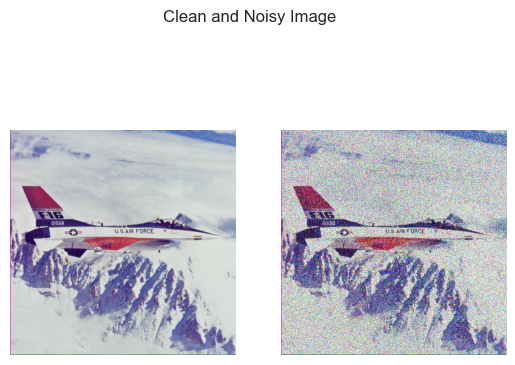

In [5]:
#load image
clean_img = './Dataset/Gaussian_Noise/Clean/F16_clean.npz'
corrupted_img = './Dataset/Gaussian_Noise/Gaussian_Noise_4/F16_Gaussian_Noise_4.npz'
raw_img_np = np.load(clean_img)['arr_0'] / 255.0
raw_img_noisy_np = np.load(corrupted_img)['arr_0'] / 255.0

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.suptitle('Clean and Noisy Image')
ax1.imshow(raw_img_np)
ax2.imshow(raw_img_noisy_np)
ax1.axis('off')
ax2.axis('off')
plt.show()
plt.close()

# original early_stopping method

In [5]:
img_np = np.transpose(raw_img_np,(2,0,1))
img_noisy_np = np.transpose(raw_img_noisy_np,(2,0,1))

img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)

# Network (exactly the same as the denoising DIP network, except with tunable width)

input_depth = 32 
n_channels = 3
    
skip_n33d = width 
skip_n33u = width 
skip_n11 = 4
num_scales = 5

net = skip(input_depth, n_channels, num_channels_down = [skip_n33d]*num_scales,
                                    num_channels_up =   [skip_n33u]*num_scales,
                                    num_channels_skip = [skip_n11]*num_scales, 
                                    upsample_mode='bilinear', downsample_mode='stride',
                                    need_sigmoid=True, need_bias=True, pad='reflection', act_fun='LeakyReLU').type(dtype) 
    
#得到原先猜的noise input
net_input = get_noise(input_depth, 'noise', (img_np.shape[1], img_np.shape[2])).type(dtype).detach()

# Loss

if l1:
    criterion = torch.nn.L1Loss().type(dtype)
else:
    criterion = torch.nn.MSELoss().type(dtype)

# Optimizer

p = get_params('net', net, net_input)  # network parameters to be optimized

if alg == 'adam':
    optimizer = torch.optim.Adam(p, lr=lr)
elif alg == 'sgd':
    optimizer = torch.optim.SGD(p, lr=lr)
else:
    assert False  

# Optimize

reg_noise_std = 1./30. 
show_every = 1
loss_history = []
psnr_history = []
ssim_history = []
ema_psnr_his = []
ema_ssim_his = []
emv_history = []
x_axis = []
ewmvar = EWMVar(alpha=alpha,p=patience)
def closure(iterator):
    #DIP
    net_input_perturbed = net_input + torch.zeros_like(net_input).normal_(std=reg_noise_std)
    # 把加了noise的input當作輸入
    r_img_torch = net(net_input_perturbed)
    # 跟原本的noisy image比較(應該改成跟每一個stage)
    total_loss = criterion(r_img_torch, img_noisy_torch)
    total_loss.backward()
    loss_history.append(total_loss.item())
    if iterator % show_every == 0:
        # evaluate recovered image (PSNR, SSIM)
        r_img_np = torch_to_np(r_img_torch)
        psnr = skimage.metrics.peak_signal_noise_ratio(img_np, r_img_np)
        temp_img_np = np.transpose(img_np,(1,2,0))
        temp_r_img_np = np.transpose(r_img_np,(1,2,0))
        ssim = skimage.metrics.structural_similarity(temp_img_np, temp_r_img_np, multichannel=True)
        psnr_history.append(psnr)
        ssim_history.append(ssim)

        #variance hisotry
        r_img_np = r_img_np.reshape(-1)
        ewmvar.update_av(r_img_np, iterator)

        tmp_ema = (ewmvar.ema).reshape(img_np.shape)
        ema_psnr = skimage.metrics.peak_signal_noise_ratio(img_np, tmp_ema)
        ema_ssim = skimage.metrics.structural_similarity(np.transpose(img_np, (1, 2, 0)),
                                                          np.transpose(tmp_ema, (1, 2, 0)), multichannel=True)
        ema_psnr_his.append(ema_psnr)
        ema_ssim_his.append(ema_ssim)
        if iterator > 100:
            emv_history.append(ewmvar.emv)
            x_axis.append(iterator)
            if ewmvar.stop == False:
                ewmvar.check_stop(iterator)
    return total_loss

In [6]:
for iterator in range(num_iter):
    optimizer.zero_grad()
    if(iterator%10 == 0):
        print(iterator)
    closure(iterator)
    optimizer.step()

0


C:\Users\fubon\AppData\Local\Temp\ipykernel_31792\1386772587.py:67: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = skimage.metrics.peak_signal_noise_ratio(img_np, r_img_np)
C:\Users\fubon\AppData\Local\Temp\ipykernel_31792\1386772587.py:70: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = skimage.metrics.structural_similarity(temp_img_np, temp_r_img_np, multichannel=True)
c:\Users\fubon\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
C:\Users\fubon\AppData\Local\Temp\ipykernel_31792\1386772587.py:79: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  ema_psnr = skimage.metrics.peak_signal_noise_ratio(img_np, tmp_ema)
C:\Users\fubon\AppData\Local\Temp\ipykernel_31792\1

10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


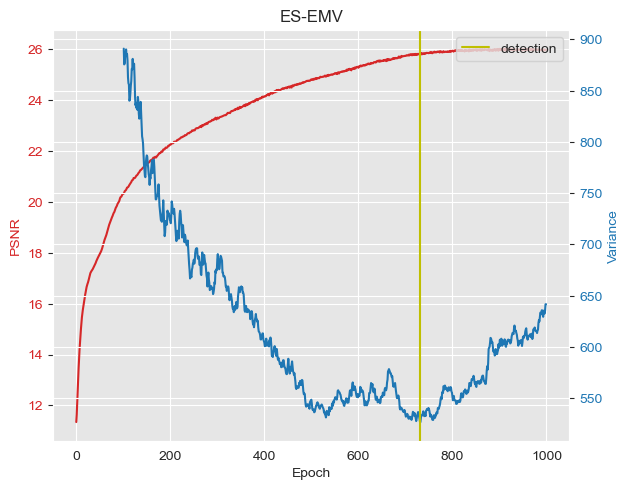

In [7]:
#show PSNR and variance history and detection
fig, ax1 = plt.subplots()

# 藍色是PSNR的結果
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('PSNR', color=color)
ax1.plot(ema_psnr_his, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()

# 紅色是variance的紀錄(跟原圖片的差異)
color = 'tab:blue'
ax2.set_ylabel('Variance', color=color)
ax2.plot(x_axis, emv_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('ES-EMV')
plt.axvline(x=ewmvar.best_epoch, label='detection',color='y')
plt.legend()
plt.show()

# applied ddpm method to DIP(original model)

### create a denoise model

In [6]:
import torch
import torch.nn as nn

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class DenoiseModel(nn.Module):
    def __init__(self, input_channels=3, hidden_channels=64, output_channels=3):
        super(DenoiseModel, self).__init__()

        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, hidden_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_channels),
            nn.ReLU(inplace=True)
        )

        self.residual_blocks = nn.Sequential(
            ResidualBlock(hidden_channels, hidden_channels),
            ResidualBlock(hidden_channels, hidden_channels),
            ResidualBlock(hidden_channels, hidden_channels)
        )

        self.final_conv = nn.Sequential(
            nn.Conv2d(hidden_channels, output_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(output_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x, t):
        out = self.initial_conv(x)
        out = self.residual_blocks(out)
        out = self.final_conv(out)
        return out


# early_stopping method apply 100 stage of noise when training

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Define helper functions to add noise
def add_noise(image, noise_level):
    noise = np.random.normal(scale=noise_level, size=image.shape)
    noisy_image = image + noise
    return np.clip(noisy_image, 0, 1)  # Clip values to keep them in the valid range


## max=5

### 利用linspace產生均勻noise level

In [7]:
# Parameters
num_steps = 10
max_noise_level = 0.5  # Maximum noise level

# Generate linearly increasing noise levels
# 分成每100個steps一個noise level
noise_levels = np.linspace(0, max_noise_level, num_steps)


In [26]:
print(noise_levels)

[0.         0.05555556 0.11111111 0.16666667 0.22222222 0.27777778
 0.33333333 0.38888889 0.44444444 0.5       ]


### 利用logarithm產生前面快的分佈

In [73]:
# Parameters
num_steps = 10
max_noise_level = 0.5  # Maximum noise level

# Generate linearly increasing noise levels
# 分成每100個steps一個noise level
noise_levels = np.linspace(0, max_noise_level, num_steps)
log_levels = []
start = 10
end = 10**1.5
log_interval = np.linspace(start, end, num_steps)
log_levels = np.log10(log_interval)
print(start,end)



10 31.622776601683793


In [84]:
print(noise_levels)
noise_levels = log_levels-1

[0.         0.09351031 0.17041021 0.23572011 0.29248032 0.3426724
 0.38766001 0.42842177 0.46568387 0.5       ]


### 利用exponential產生後面快的分佈

In [91]:
# Parameters
num_steps = 10
max_noise_level = 0.5  # Maximum noise level

# Generate linearly increasing noise levels
# 分成每100個steps一個noise level
exp_levels = np.logspace(np.log10(1), np.log10(1.5), num_steps)-1



In [92]:
print(exp_levels)

[0.         0.04608192 0.09428738 0.14471424 0.19746487 0.25264635
 0.3103707  0.37075509 0.43392212 0.5       ]


### 增加corrupt的程度

In [101]:
# Parameters
num_steps = 10
max_noise_level = 1  # Maximum noise level

# Generate linearly increasing noise levels
# 分成每100個steps一個noise level
noise_levels = np.linspace(0, max_noise_level, num_steps)


In [102]:
print(noise_levels)

[0.         0.11111111 0.22222222 0.33333333 0.44444444 0.55555556
 0.66666667 0.77777778 0.88888889 1.        ]


### 減少corrupt的程度

In [109]:
# Parameters
num_steps = 10
max_noise_level = 0.25  # Maximum noise level

# Generate linearly increasing noise levels
# 分成每100個steps一個noise level
noise_levels = np.linspace(0, max_noise_level, num_steps)


In [110]:
print(noise_levels)

[0.         0.02777778 0.05555556 0.08333333 0.11111111 0.13888889
 0.16666667 0.19444444 0.22222222 0.25      ]


### 產生level圖片

In [111]:
# Load or create a clean image
# For example purposes, let's create a dummy image (a simple gradient)
clean_image = np.tile(np.linspace(0, 1, 256), (256, 1))
input_depth = 32 
n_channels = 3
# Generate corrupted images
corrupted_images = []
for noise_level in noise_levels:
    net_input = get_noise(input_depth, 'noise', (img_np.shape[1], img_np.shape[2]),var=noise_level ).type(dtype).detach()
    corrupted_image = add_noise(raw_img_np, noise_level)
    corrupted_images.append(corrupted_image)


In [112]:
img_np = np.transpose(raw_img_np,(2,0,1))
# 這邊改成custom的noisy image(已經是np array了)
# Initialize a list to store the torch tensors
img_noisy_torch_list = []

# Convert each corrupted image and store the tensor
for corrupted_image in corrupted_images:
    # Transpose the image array to shape (channels, height, width)
    img_noisy_np = np.transpose(corrupted_image, (2, 0, 1))
    
    # Convert the NumPy array to a torch tensor and cast to the desired dtype
    img_noisy_torch = np_to_torch(img_noisy_np).type(dtype)
    
    # Append the tensor to the list
    img_noisy_torch_list.append(img_noisy_torch)

# Optionally, stack all tensors into a single tensor for batch processing
img_noisy_torch_batch = torch.stack(img_noisy_torch_list)

# Network (exactly the same as the denoising DIP network, except with tunable width)

In [113]:
print(img_noisy_torch_batch[1])
                                     
print(img_noisy_torch)

tensor([[[[0.6920, 0.7364, 0.6766,  ..., 0.5978, 0.6376, 0.5147],
          [0.5560, 0.7517, 0.7312,  ..., 0.6112, 0.5472, 0.4758],
          [0.5409, 0.7811, 0.7312,  ..., 0.6617, 0.5727, 0.4267],
          ...,
          [0.6320, 0.8756, 0.8182,  ..., 0.7241, 0.6912, 0.5985],
          [0.6456, 0.8568, 0.8631,  ..., 0.6582, 0.7477, 0.6481],
          [0.1090, 0.1286, 0.1309,  ..., 0.3752, 0.4505, 0.4228]],

         [[0.0000, 0.8301, 0.8277,  ..., 0.6427, 0.6177, 0.6155],
          [0.0064, 0.7128, 0.7549,  ..., 0.7057, 0.6159, 0.5917],
          [0.0000, 0.7410, 0.7358,  ..., 0.7131, 0.6295, 0.5675],
          ...,
          [0.0000, 0.8391, 0.8481,  ..., 0.7304, 0.6941, 0.5619],
          [0.0000, 0.8518, 0.8715,  ..., 0.6323, 0.6702, 0.6754],
          [0.4811, 0.4614, 0.5262,  ..., 0.4629, 0.4423, 0.4571]],

         [[0.4300, 0.7778, 0.7546,  ..., 0.7475, 0.7762, 0.7706],
          [0.4001, 0.7898, 0.7942,  ..., 0.8149, 0.7484, 0.7470],
          [0.4302, 0.8327, 0.8093,  ..., 0

In [114]:

    
skip_n33d = width 
skip_n33u = width 
skip_n11 = 4
num_scales = 5

net = skip(input_depth, n_channels, num_channels_down = [skip_n33d]*num_scales,
                                    num_channels_up =   [skip_n33u]*num_scales,
                                    num_channels_skip = [skip_n11]*num_scales, 
                                    upsample_mode='bilinear', downsample_mode='stride',
                                    need_sigmoid=True, need_bias=True, pad='reflection', act_fun='LeakyReLU').type(dtype) 
    
net_input = get_noise(input_depth, 'noise', (img_np.shape[1], img_np.shape[2])).type(dtype).detach()
    
# Loss

if l1:
    criterion = torch.nn.L1Loss().type(dtype)
else:
    criterion = torch.nn.MSELoss().type(dtype)

# Optimizer

p = get_params('net', net, net_input)  # network parameters to be optimized

if alg == 'adam':
    optimizer = torch.optim.Adam(p, lr=lr)
elif alg == 'sgd':
    optimizer = torch.optim.SGD(p, lr=lr)
else:
    assert False  

# Optimize

reg_noise_std = 1./30. 
show_every = 1
loss_history = []
psnr_history = []
ssim_history = []
ema_psnr_his = []
ema_ssim_his = []
emv_history = []
x_axis = []
ewmvar = EWMVar(alpha=alpha,p=patience)
def closure(iterator):
    # (original)get random noise
    net_input_perturbed = net_input + torch.zeros_like(net_input).normal_(std=reg_noise_std)
    # (my version)take the nth corrupted image as input
    #DIP
    # 把加了noise的input當作輸入
    # total_loss = criterion(r_img_torch, img_noisy_torch)
    r_img_torch = net(net_input_perturbed)
    # 算loss，先跟corrupt最嚴重的算，每個不同level的corrupt都算一次，代表有1000個stage
    if iterator <= 1000:
        total_loss = criterion(r_img_torch, img_noisy_torch_batch[int(9-iterator/100)])
    else:
        total_loss = criterion(r_img_torch, img_noisy_torch_batch[9])

    total_loss.backward()
    loss_history.append(total_loss.item())
    if iterator % show_every == 0:
        # evaluate recovered image (PSNR, SSIM)
        r_img_np = torch_to_np(r_img_torch)
        psnr = skimage.metrics.peak_signal_noise_ratio(img_np, r_img_np)
        temp_img_np = np.transpose(img_np,(1,2,0))
        temp_r_img_np = np.transpose(r_img_np,(1,2,0))
        ssim = skimage.metrics.structural_similarity(temp_img_np, temp_r_img_np, multichannel=True)
        psnr_history.append(psnr)
        ssim_history.append(ssim)

        #variance hisotry
        r_img_np = r_img_np.reshape(-1)
        ewmvar.update_av(r_img_np, iterator)

        tmp_ema = (ewmvar.ema).reshape(img_np.shape)
        ema_psnr = skimage.metrics.peak_signal_noise_ratio(img_np, tmp_ema)
        ema_ssim = skimage.metrics.structural_similarity(np.transpose(img_np, (1, 2, 0)),
                                                          np.transpose(tmp_ema, (1, 2, 0)), multichannel=True)
        ema_psnr_his.append(ema_psnr)
        ema_ssim_his.append(ema_ssim)
        if iterator > 100:
            emv_history.append(ewmvar.emv)
            x_axis.append(iterator)
            if ewmvar.stop == False:
                ewmvar.check_stop(iterator)
    return total_loss

In [115]:
for iterator in range(1000):
    optimizer.zero_grad()
    if(iterator%10 == 0)or(iterator<5):
        print(iterator)
    closure(iterator)
    optimizer.step()

0


C:\Users\fubon\AppData\Local\Temp\ipykernel_24876\47864324.py:63: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = skimage.metrics.peak_signal_noise_ratio(img_np, r_img_np)
C:\Users\fubon\AppData\Local\Temp\ipykernel_24876\47864324.py:66: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = skimage.metrics.structural_similarity(temp_img_np, temp_r_img_np, multichannel=True)
C:\Users\fubon\AppData\Local\Temp\ipykernel_24876\47864324.py:75: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  ema_psnr = skimage.metrics.peak_signal_noise_ratio(img_np, tmp_ema)
C:\Users\fubon\AppData\Local\Temp\ipykernel_24876\47864324.py:76: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ema_ssim = skimag

1
2
3
4
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990


### result of linear distribution

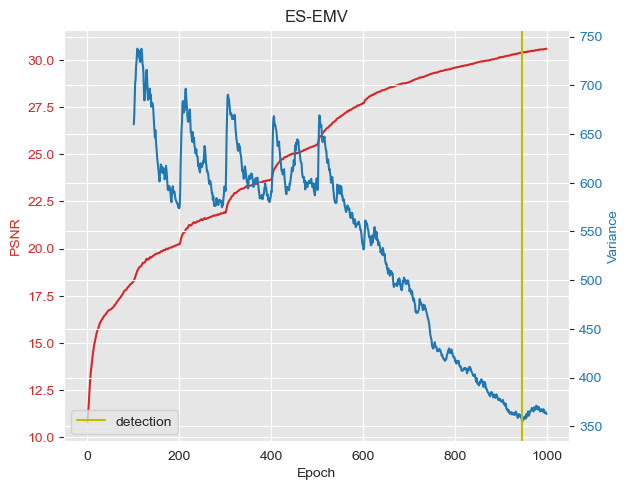

In [25]:
#show PSNR and variance history and detection
fig, ax1 = plt.subplots()

# 藍色是PSNR的結果
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('PSNR', color=color)
ax1.plot(ema_psnr_his, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()

# 紅色是variance的紀錄(跟原圖片的差異)
color = 'tab:blue'
ax2.set_ylabel('Variance', color=color)
ax2.plot(x_axis, emv_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('ES-EMV')
plt.axvline(x=ewmvar.best_epoch, label='detection',color='y')
plt.legend()
plt.show()

### result of logarithm distribution

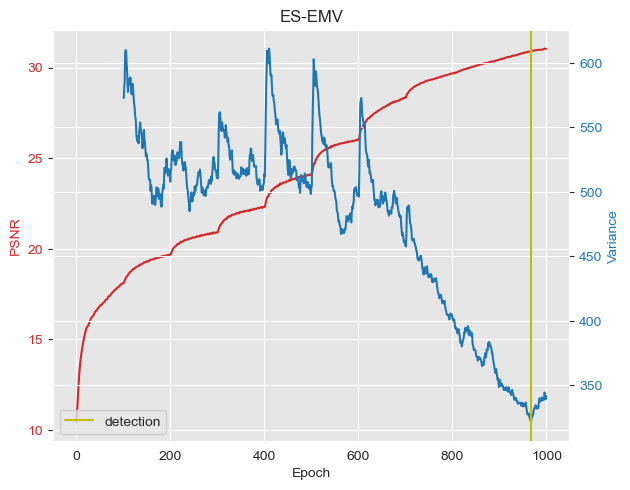

In [90]:
#show PSNR and variance history and detection
fig, ax1 = plt.subplots()

# 藍色是PSNR的結果
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('PSNR', color=color)
ax1.plot(ema_psnr_his, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()

# 紅色是variance的紀錄(跟原圖片的差異)
color = 'tab:blue'
ax2.set_ylabel('Variance', color=color)
ax2.plot(x_axis, emv_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('ES-EMV')
plt.axvline(x=ewmvar.best_epoch, label='detection',color='y')
plt.legend()
plt.show()

### result of exponential distribution

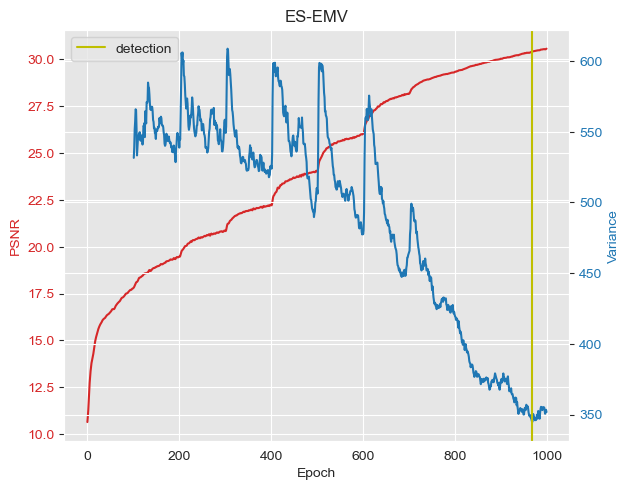

In [98]:
#show PSNR and variance history and detection
fig, ax1 = plt.subplots()

# 藍色是PSNR的結果
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('PSNR', color=color)
ax1.plot(ema_psnr_his, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()

# 紅色是variance的紀錄(跟原圖片的差異)
color = 'tab:blue'
ax2.set_ylabel('Variance', color=color)
ax2.plot(x_axis, emv_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('ES-EMV')
plt.axvline(x=ewmvar.best_epoch, label='detection',color='y')
plt.legend()
plt.show()

### result of linear with max = 1

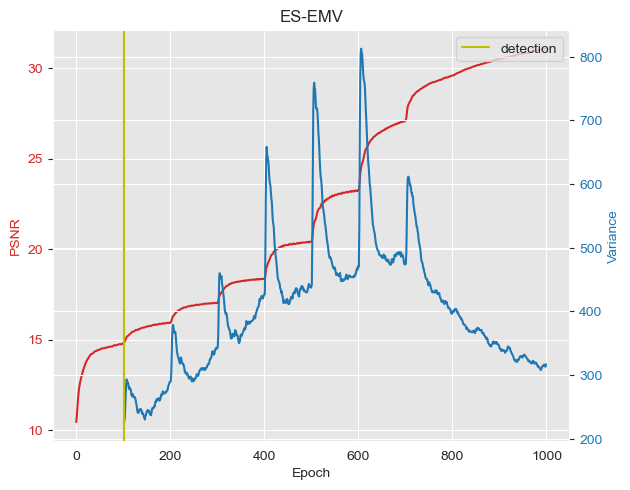

In [108]:
#show PSNR and variance history and detection
fig, ax1 = plt.subplots()

# 藍色是PSNR的結果
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('PSNR', color=color)
ax1.plot(ema_psnr_his, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()

# 紅色是variance的紀錄(跟原圖片的差異)
color = 'tab:blue'
ax2.set_ylabel('Variance', color=color)
ax2.plot(x_axis, emv_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('ES-EMV')
plt.axvline(x=ewmvar.best_epoch, label='detection',color='y')
plt.legend()
plt.show()

### result of linear with max = 0.25

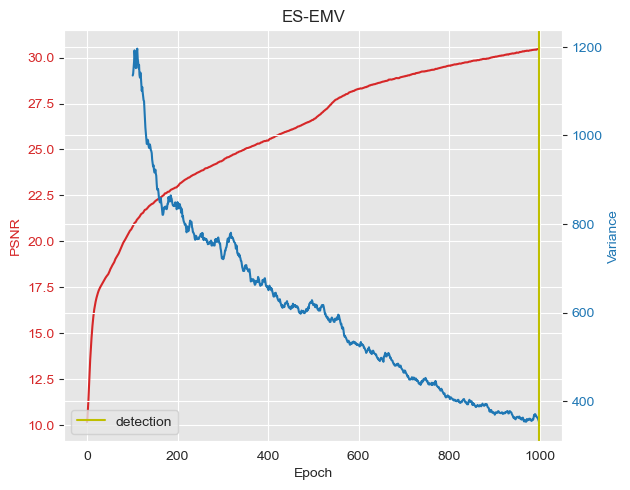

In [116]:
#show PSNR and variance history and detection
fig, ax1 = plt.subplots()

# 藍色是PSNR的結果
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('PSNR', color=color)
ax1.plot(ema_psnr_his, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()

# 紅色是variance的紀錄(跟原圖片的差異)
color = 'tab:blue'
ax2.set_ylabel('Variance', color=color)
ax2.plot(x_axis, emv_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('ES-EMV')
plt.axvline(x=ewmvar.best_epoch, label='detection',color='y')
plt.legend()
plt.show()

# baseline ddpm method

In [65]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import os

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True
dtype = torch.cuda.FloatTensor

# Define paths to your data
clean_img_path = './Dataset/Gaussian_Noise/Clean/F16_clean.npz'
corrupted_img_path = './Dataset/Gaussian_Noise/Gaussian_Noise_4/F16_Gaussian_Noise_4.npz'

# Load the data
clean_img_np = np.load(clean_img_path)['arr_0'] / 255.0
corrupted_img_np = np.load(corrupted_img_path)['arr_0'] / 255.0
print(clean_img_np.shape)
# Convert to PyTorch tensors
clean_img = torch.tensor(clean_img_np).permute(2, 0, 1).unsqueeze(0).type(dtype)  # Shape: [1, 3, 512, 512]
corrupted_img = torch.tensor(corrupted_img_np).permute(2, 0, 1).unsqueeze(0).type(dtype)  # Shape: [1, 3, 512, 512]print(clean_img.shape)
print(clean_img.shape)

(512, 512, 3)
torch.Size([1, 3, 512, 512])


In [58]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, features=64):
        super(UNet, self).__init__()
        self.encoder1 = self.conv_block(in_channels, features)
        self.encoder2 = self.conv_block(features, features * 2)
        self.encoder3 = self.conv_block(features * 2, features * 4)
        self.encoder4 = self.conv_block(features * 4, features * 8)
        self.bottleneck = self.conv_block(features * 8, features * 16)
        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2, stride=2)
        self.decoder4 = self.conv_block((features * 8) * 2, features * 8)
        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = self.conv_block((features * 4) * 2, features * 4)
        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = self.conv_block((features * 2) * 2, features * 2)
        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = self.conv_block(features * 2, features)
        self.conv = nn.Conv2d(features, out_channels, kernel_size=1)
        
    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(F.max_pool2d(enc1, kernel_size=2, stride=2))
        enc3 = self.encoder3(F.max_pool2d(enc2, kernel_size=2, stride=2))
        enc4 = self.encoder4(F.max_pool2d(enc3, kernel_size=2, stride=2))
        bottleneck = self.bottleneck(F.max_pool2d(enc4, kernel_size=2, stride=2))
        dec4 = self.upconv4(bottleneck)
        dec4 = torch.cat((dec4, enc4), dim=1)
        dec4 = self.decoder4(dec4)
        dec3 = self.upconv3(dec4)
        dec3 = torch.cat((dec3, enc3), dim=1)
        dec3 = self.decoder3(dec3)
        dec2 = self.upconv2(dec3)
        dec2 = torch.cat((dec2, enc2), dim=1)
        dec2 = self.decoder2(dec2)
        dec1 = self.upconv1(dec2)
        dec1 = torch.cat((dec1, enc1), dim=1)
        dec1 = self.decoder1(dec1)
        return self.conv(dec1)

# Initialize the DDPM model
model = UNet(in_channels=3, out_channels=3).type(dtype)
optimizer = optim.Adam(model.parameters(), lr=0.01)


In [59]:
def linear_beta_schedule(timesteps, beta_start=0.0001, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps).type(dtype)

timesteps = 1000
betas = linear_beta_schedule(timesteps)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)

def sample_timesteps(num_samples, timesteps):
    return torch.randint(0, timesteps, (num_samples,)).type(dtype)

def get_noisy_image(image, t, noise):
    return sqrt_alphas_cumprod[t] * image + sqrt_one_minus_alphas_cumprod[t] * noise


In [83]:
ewmvar = EWMVar(alpha=0.1, p=1000)
num_epochs = 1000
batch_size = 1  # Since we have single images, using batch size of 1
l1 = False  # Using L2 loss for simplicity

show_every = 1
loss_history = []
psnr_history = []
ssim_history = []
ema_psnr_his = []
ema_ssim_his = []
emv_history = []
x_axis = []

for iterator in range(num_epochs):
    
    net_input_perturbed = net_input + torch.zeros_like(net_input).normal_(std=reg_noise_std)
    # 把加了noise的input當作輸入
    r_img_torch = net(net_input_perturbed)
    # 跟原本的noisy image比較(應該改成跟每一個stage)
    total_loss = criterion(r_img_torch, img_noisy_torch)
    total_loss.backward()
    loss_history.append(total_loss.item())

    
    if iterator % show_every == 0:
            # evaluate recovered image (PSNR, SSIM)
            r_img_np = torch_to_np(r_img_torch)
            # print(r_img_np.shape)
            # print(img_np.shape)
            psnr = skimage.metrics.peak_signal_noise_ratio(img_np, r_img_np)
            temp_img_np = np.transpose(img_np,(1,2,0))
            temp_r_img_np = np.transpose(r_img_np,(1,2,0))
            ssim = skimage.metrics.structural_similarity(temp_img_np, temp_r_img_np, multichannel=True)
            psnr_history.append(psnr)
            ssim_history.append(ssim)

            #variance hisotry
            r_img_np = r_img_np.reshape(-1)
            ewmvar.update_av(r_img_np, iterator)

            tmp_ema = (ewmvar.ema).reshape(img_np.shape)
            ema_psnr = skimage.metrics.peak_signal_noise_ratio(img_np, tmp_ema)
            ema_ssim = skimage.metrics.structural_similarity(np.transpose(img_np, (1, 2, 0)),
                                                            np.transpose(tmp_ema, (1, 2, 0)), multichannel=True)
            ema_psnr_his.append(ema_psnr)
            ema_ssim_his.append(ema_ssim)
            if iterator > 100:
                emv_history.append(ewmvar.emv)
                x_axis.append(iterator)
                if ewmvar.stop == False:
                    ewmvar.check_stop(iterator)

    if ewmvar.stop:
        print(f"Early stopping at epoch {iterator}")
        break

    if iterator % 100 == 0:
        print(f"Epoch {iterator}, Loss: {loss.item()},best : {ewmvar.best_epoch}")

# Save the model
torch.save(model.state_dict(), 'ddpm_denoising_model.pth')


C:\Users\fubon\AppData\Local\Temp\ipykernel_2164\1095634414.py:31: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  psnr = skimage.metrics.peak_signal_noise_ratio(img_np, r_img_np)
C:\Users\fubon\AppData\Local\Temp\ipykernel_2164\1095634414.py:34: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim = skimage.metrics.structural_similarity(temp_img_np, temp_r_img_np, multichannel=True)
c:\Users\fubon\anaconda3\lib\site-packages\skimage\_shared\utils.py:348: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  return func(*args, **kwargs)
C:\Users\fubon\AppData\Local\Temp\ipykernel_2164\1095634414.py:43: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  ema_psnr = skimage.metrics.peak_signal_noise_ratio(img_np, tmp_ema)
C:\Users\fubon\AppData\Local\Temp\ipykernel_2164\10956

Epoch 0, Loss: 1.0026068687438965,best : 0
Epoch 100, Loss: 1.0026068687438965,best : 0
Epoch 200, Loss: 1.0026068687438965,best : 106
Epoch 300, Loss: 1.0026068687438965,best : 267
Epoch 400, Loss: 1.0026068687438965,best : 382
Epoch 500, Loss: 1.0026068687438965,best : 403
Epoch 600, Loss: 1.0026068687438965,best : 517
Epoch 700, Loss: 1.0026068687438965,best : 517
Epoch 800, Loss: 1.0026068687438965,best : 517
Epoch 900, Loss: 1.0026068687438965,best : 517


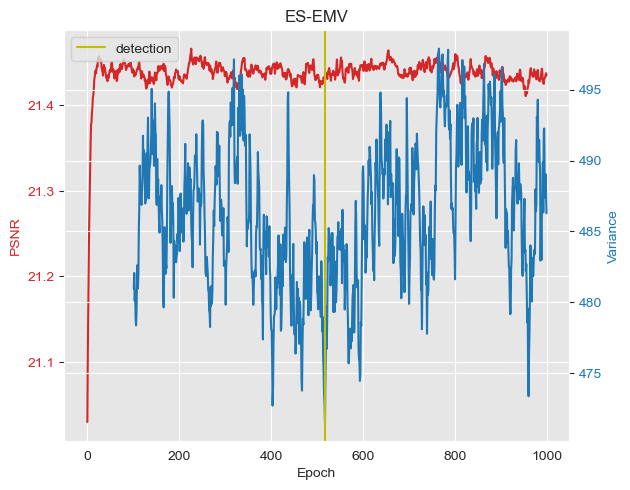

In [84]:
#show PSNR and variance history and detection
fig, ax1 = plt.subplots()

# 藍色是PSNR的結果
color = 'tab:red'
ax1.set_xlabel('Epoch')
ax1.set_ylabel('PSNR', color=color)
ax1.plot(ema_psnr_his, color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax2 = ax1.twinx()

# 紅色是variance的紀錄(跟原圖片的差異)
color = 'tab:blue'
ax2.set_ylabel('Variance', color=color)
ax2.plot(x_axis, emv_history, color=color)
ax2.tick_params(axis='y', labelcolor=color)
fig.tight_layout()
plt.title('ES-EMV')
plt.axvline(x=ewmvar.best_epoch, label='detection',color='y')
plt.legend()
plt.show()